===================================================  
Employees Burn Out : Analysis and Prediciton

Nama = __Angger Rizky Firdaus__  
This project is developed to accomplish milestone 2 of the FTDS Hacktiv8 program.  
Creating a regression model to predict the level of Employee Burnout.

===================================================

__Objective__

As a representative of the data science team in the HR department, I have been tasked with creating a predictive model to forecast the level of employee burnout across the organization. The application of this model is expected to be usable by individuals unfamiliar with Python. Therefore, the model must be deployed to the Hugging Face website for use by the HR team. Various models will be utilized until obtaining the one with optimal performance.

[__Hugging Face Deploy Link__](https://huggingface.co/spaces/batraccoon/Burn_Out_Score_Prediction)

# Library

In [1]:
#install the lightgbm library to use the lightgbm boost model
!pip install lightgbm

In [2]:
#import the library used for this project
import opendatasets as od
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer
from scipy.stats import kendalltau, pearsonr
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import pickle
import json
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

# Data Loading

In [3]:
# syntax for downloading files from Kaggle using functions from the OpenDatasets library
# od.download('https://www.kaggle.com/datasets/blurredmachine/are-your-employees-burning-out/')


The data has been successfully downloaded from Kaggle.

In [4]:
# reading train data from CSV
train = pd.read_csv('train.csv')


In [5]:
#Displays train data loaded from CSV
train.head(5)

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


The dataset is displayed successfully

In [6]:
#Assign a new variable to display the dataset
df_train = train.copy()

data copied successfully

In [7]:
#summary of train data
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee ID           22750 non-null  object 
 1   Date of Joining       22750 non-null  object 
 2   Gender                22750 non-null  object 
 3   Company Type          22750 non-null  object 
 4   WFH Setup Available   22750 non-null  object 
 5   Designation           22750 non-null  float64
 6   Resource Allocation   21369 non-null  float64
 7   Mental Fatigue Score  20633 non-null  float64
 8   Burn Rate             21626 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.6+ MB


From this training data, it can be observed that there are 22750 rows/data with 9 columns. There are missing values in the price column which will be handled later. Based on observation, the data type for the date of joining column is not consistent with its values, it should be datetime.

In [8]:
#change the Date Of Joining datatype to datetime64
df_train['Date of Joining'] = df_train['Date of Joining'].astype('datetime64[ns]')


In [9]:
#checking whether the datatype is correct
df_train['Date of Joining'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 22750 entries, 0 to 22749
Series name: Date of Joining
Non-Null Count  Dtype         
--------------  -----         
22750 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 177.9 KB


Datatype has successfully become datetime64[ns]

In [10]:
#Checking for missing values ​​in train data
df_train.isnull().sum()

Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1381
Mental Fatigue Score    2117
Burn Rate               1124
dtype: int64

there are missing values ​​in the Resource Allocation, Mental Fatigue Score, and Burn Rate columns

In [11]:
#display the shape of the train data
df_train.shape

(22750, 9)

as previously explained, the train dataset has 22750 rows with 9 columns.

In [12]:
#duplicate checking
df_train.duplicated().sum()

0

no duplicate data

__Dataset Information__

In [13]:
#display the columns contained in the dataset.
df_train.columns

Index(['Employee ID', 'Date of Joining', 'Gender', 'Company Type',
       'WFH Setup Available', 'Designation', 'Resource Allocation',
       'Mental Fatigue Score', 'Burn Rate'],
      dtype='object')

| Feature                   | Description                                                                                               |
|-------------------------|-----------------------------------------------------------------------------------------------------------|
| Employee ID             | The unique ID allocated for each employee (example: fffe390032003000)                                      |
| Date of Joining         | The date-time when the employee has joined the organization (example: 2008-12-30)                           |
| Gender                  | The gender of the employee (Male/Female)                                                                  |
| Company Type            | The type of company where the employee is working (Service/Product)                                        |
| WFH Setup Available     | Is the work from home facility available for the employee (Yes/No)                                         |
| Designation             | The designation of the employee of work in the organization. In the range of [0.0, 5.0] bigger is higher designation. |
| Resource Allocation     | The amount of resource allocated to the employee to work, ie. number of working hours. In the range of [1.0, 10.0] (higher means more resource) |
| Mental Fatigue Score    | The level of fatigue mentally the employee is facing. In the range of [0.0, 10.0] where 0.0 means no fatigue and 10.0 means completely fatigue. |
| Burn Rate               | The value we need to predict for each employee telling the rate of Burn out while working. In the range of [0.0, 1.0] where the higher the value is more is the burn out. |


In [14]:
#display unique values ​​from data
kols = []
unik = []

for kol in list(df_train.columns):
    unik_val = df_train[kol].unique()

    kols.append(kol)
    unik.append(unik_val)

    print(kol)
    print(unik_val)


Employee ID
['fffe32003000360033003200' 'fffe3700360033003500'
 'fffe31003300320037003900' ... 'fffe390032003000'
 'fffe33003300320036003900' 'fffe3400350031003800']
Date of Joining
<DatetimeArray>
['2008-09-30 00:00:00', '2008-11-30 00:00:00', '2008-03-10 00:00:00',
 '2008-11-03 00:00:00', '2008-07-24 00:00:00', '2008-11-26 00:00:00',
 '2008-01-02 00:00:00', '2008-10-31 00:00:00', '2008-12-27 00:00:00',
 '2008-03-09 00:00:00',
 ...
 '2008-05-24 00:00:00', '2008-06-10 00:00:00', '2008-03-31 00:00:00',
 '2008-12-01 00:00:00', '2008-01-05 00:00:00', '2008-09-15 00:00:00',
 '2008-12-10 00:00:00', '2008-02-10 00:00:00', '2008-12-03 00:00:00',
 '2008-02-01 00:00:00']
Length: 366, dtype: datetime64[ns]
Gender
['Female' 'Male']
Company Type
['Service' 'Product']
WFH Setup Available
['No' 'Yes']
Designation
[2. 1. 3. 0. 4. 5.]
Resource Allocation
[ 3.  2. nan  1.  7.  4.  6.  5.  8. 10.  9.]
Mental Fatigue Score
[ 3.8  5.   5.8  2.6  6.9  3.6  7.9  4.4  nan  5.3  1.8  4.7  5.9  6.7
  4.   7.6 

In [15]:
#Syntax displays the number of unique values
listItem = []
for col in df_train.columns:
  listItem.append([col, df_train[col].nunique()])

pd.DataFrame(columns=['Column', 'number of unique values'], data=listItem)

,Column,number of unique values
0,Employee ID,22750
1,Date of Joining,366
2,Gender,2
3,Company Type,2
4,WFH Setup Available,2
5,Designation,6
6,Resource Allocation,10
7,Mental Fatigue Score,101
8,Burn Rate,101


Based on the information displayed above, data types can be divided into:
- Numeric Continous = Designation, Resource Allocation, Mental Fatigue Score, Burn Rate
- String Continous = Employee ID
- Datetime =  Date of Joining
- String Categorical = Gender, Company Type, WFH Setup Available,

__Must Do!__

- Handling missing values ​​in the Resource Allocation, Mental Fatigue Score and Burn Rate columns
- Feature engineering

# Exploratory Data Analysis (EDA)

In [16]:
#Assign new variables for exploratory data analysis (EDA) tasks.
eda = df_train.copy()

In [17]:
eda.head(5)

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [18]:
#display eda column
eda.columns

Index(['Employee ID', 'Date of Joining', 'Gender', 'Company Type',
       'WFH Setup Available', 'Designation', 'Resource Allocation',
       'Mental Fatigue Score', 'Burn Rate'],
      dtype='object')

In [19]:
eda.describe().T

,count,mean,min,25%,50%,75%,max,std
Date of Joining,22750,2008-07-01 09:28:05.274725120,2008-01-01 00:00:00,2008-04-01 00:00:00,2008-07-02 00:00:00,2008-09-30 00:00:00,2008-12-31 00:00:00,NaN
Designation,22750.0,2.178725,0.0,1.0,2.0,3.0,5.0,1.135145
Resource Allocation,21369.0,4.481398,1.0,3.0,4.0,6.0,10.0,2.047211
Mental Fatigue Score,20633.0,5.728188,0.0,4.6,5.9,7.1,10.0,1.920839
Burn Rate,21626.0,0.452005,0.0,0.31,0.45,0.59,1.0,0.198226


## Distribution of Mental Fatigue Score Columns

<Axes: title={'center': 'Mental Fatigue Score'}>

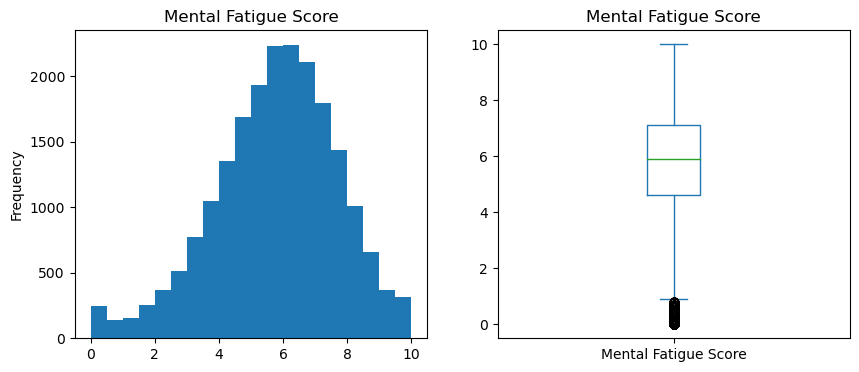

In [20]:
#Displays a histogram and boxplot in the Mental Fatigue Score column
fig, ax = plt.subplots(ncols=2,figsize=(10,4))

eda['Mental Fatigue Score'].plot(kind='hist',bins=20,ax=ax[0],title='Mental Fatigue Score')
eda['Mental Fatigue Score'].plot(kind='box',ax=ax[1],title='Mental Fatigue Score')


In [21]:
# Assign formulas for mean and median
mean_score = eda['Mental Fatigue Score'].mean()
median_score = eda['Mental Fatigue Score'].median()
min_score = eda['Mental Fatigue Score'].min()
skewness_score = eda['Mental Fatigue Score'].skew()

# Displaying the mean and median values in the Mental Fatigue Score column.
print(f'Minimum score: {min_score}')
print(f'Mean score: {mean_score}')
print(f'Median score: {median_score}')
print(f'Skewness score: {skewness_score}')

Minimum score: 0.0
Mean score: 5.728187854407987
Median score: 5.9
Skewness score: -0.4308950578815428


__Explanation__

In the visualization through the boxplot, the column "Mental Fatigue Score" exhibits outliers, which are validated by the skewness value of -0.43. A skewness value of -0.43 indicates that the data is relatively normally distributed, albeit slightly skewed to the right (negative skewness).

This means that the average mental fatigue score ranges from 5.7 to 5.9, indicating a relatively high level of stress, even reaching its peak at a score of 10. However, employees who do not feel stressed or have low stress scores are outliers in this data, indicating that employees who do not feel stressed or have low stress levels are rare occurrences.

## Distribution of Employee Position Level Columns

<Axes: title={'center': 'Designation'}>

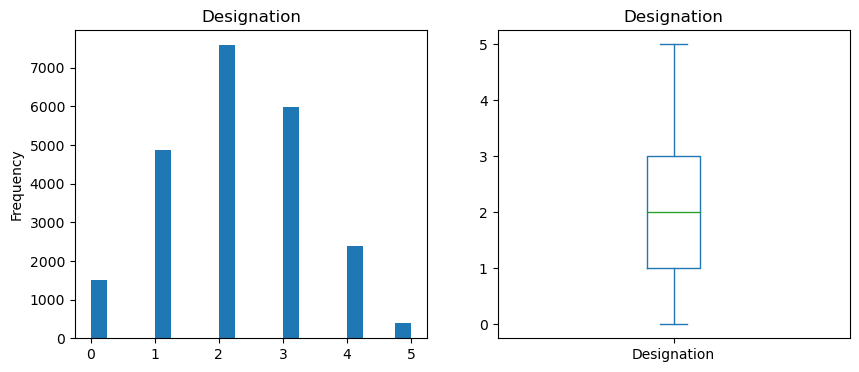

In [22]:
#Display histograph and boxplot in the Designation column
fig, ax = plt.subplots(ncols=2,figsize=(10,4))

eda['Designation'].plot(kind='hist',bins=20,ax=ax[0],title='Designation')
eda['Designation'].plot(kind='box',ax=ax[1],title='Designation')

In [23]:
#assign formulas for mean and median
m = eda['Designation'].mean()
me = eda['Designation'].median()
mi = eda['Designation'].min()
sk = eda['Designation'].skew()

#display the mean and median values in the Designation column.
print(f'Minimum score: {mi}')
print(f'Mean score: {m}')
print(f'Median score: {me}')
print(f'Skewness value: {sk}')


Minimum score: 0.0
Mean score: 2.1787252747252746
Median score: 2.0
Skewness value: 0.09242138478903683


__Explanation__

In the visualization via boxplot, the "Designation" column does not have outliers, validated by a skewness value of 0.092. A skewness value of 0.092 indicates normally distributed data, depicted in the boxplot without outliers. This may be due to the data being only filled with numbers ranging from 0 to 5.

This means that among all employees, the most common designation level is at level 2. This is evidenced by the mode, mean, and median which are at level 2. Individuals with higher levels such as levels 4 and 5 have fewer numbers compared to levels 2 and 3. Lower levels such as 0 and 1 also do not have as many instances as levels 2 and 3.


## Distribution of Resource Allocation Columns

<Axes: title={'center': 'Resource Allocation'}>

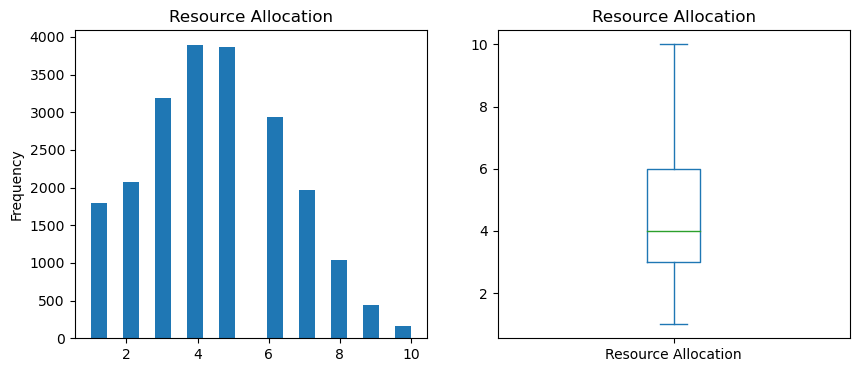

In [24]:
#Displays a histograph and boxplot in the Resource Allocation column
fig, ax = plt.subplots(ncols=2,figsize=(10,4))

eda['Resource Allocation'].plot(kind='hist',bins=20,ax=ax[0],title='Resource Allocation')
eda['Resource Allocation'].plot(kind='box',ax=ax[1],title='Resource Allocation')

In [92]:
# Assign formulas for mean and median
m = eda['Resource Allocation'].mean()
me = eda['Resource Allocation'].median()
mi = eda['Resource Allocation'].min()
sk = eda['Resource Allocation'].skew()

# Displaying the mean and median values for the Resource Allocation column.
print(f'Minimum score: {mi}')
print(f'Mean score: {m}')
print(f'Median score: {me}')
print(f'Skewness value: {sk}')


Minimum score: 1.0
Mean score: 4.481398287238523
Median score: 4.0
Skewness value: 0.20457273454318103


__Explanation__

Visually, in the boxplot, the resource allocation column does not have outliers, as validated by a skewness value of 0.2. A skewness value of 0.2 indicates that the data is relatively normally distributed, and there are no outliers depicted in the boxplot. This could be attributed to the data being filled with numbers ranging from 0 to 10.

This implies that, among all employees, the majority have resource allocation levels at 4 and 5. This is evidenced by the mode, mean, and median values being around 4 and 5. Individuals with high resource allocation levels (8-10) are very few. There is a possibility that this is influenced by the employees' positions, which will be confirmed with the scatterplot below.

## Scatterplot visualization for number of hours worked by position.

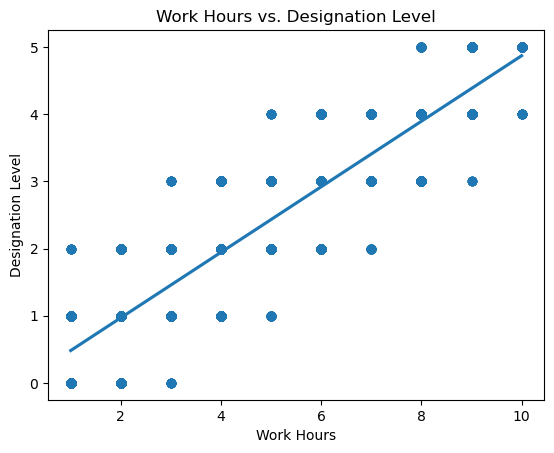

In [93]:
#syntax for scatterplot visualization with seaborn
sns.regplot(x=df_train["Resource Allocation"], y=df_train["Designation"])
plt.xlabel('Work Hours')
plt.ylabel('Designation Level')
plt.title('Work Hours vs. Designation Level')
plt.show()


Based on this scatterplot, there is a linear correlation with working hours and position level. The meaning of this visualization is that the higher the position, the more hours you work. If the position is low then the working hours will also be low.

## Burn Rate Column Distribution Spread

<Axes: title={'center': 'Burn Rate'}>

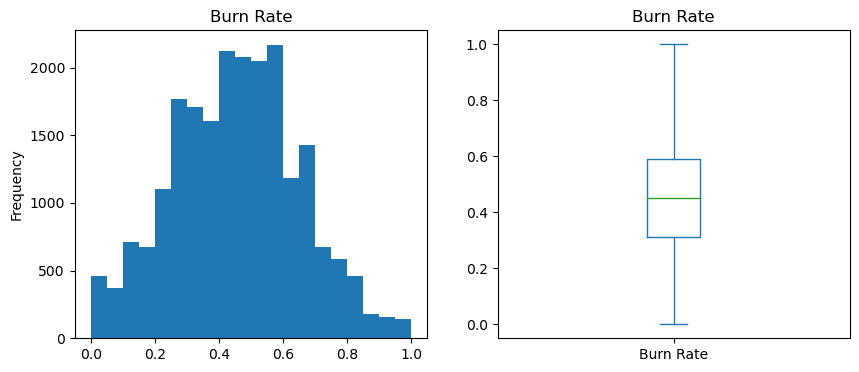

In [27]:
#Displays a histogram and boxplot in the Burn Rate column
fig, ax = plt.subplots(ncols=2,figsize=(10,4))

eda['Burn Rate'].plot(kind='hist',bins=20,ax=ax[0],title='Burn Rate')
eda['Burn Rate'].plot(kind='box',ax=ax[1],title='Burn Rate')

In [94]:
# Calculate mean and median for Burn Rate column
m = eda['Burn Rate'].mean()
me = eda['Burn Rate'].median()
mi = eda['Burn Rate'].min()
sk = eda['Burn Rate'].skew()

# Display the minimum score, mean, median, and skewness for the Burn Rate column
print(f'Minimum Score: {mi}')
print(f'Mean: {m}')
print(f'Median: {me}')
print(f'Skewness: {sk}')

Minimum Score: 0.0
Mean: 0.45200545639508
Median: 0.45
Skewness: 0.045737370909640515


__Explanation__

In the visualization through the boxplot, the Burn Rate column exhibits no outliers, validated by a skewness value of 0.045. This skewness value indicates a normal distribution of data, as depicted in the boxplot where no outliers are evident. Additionally, the equality between the median and mean of this data represents typical characteristics of a normally distributed dataset. This normal distribution is attributed to the predefined range used to fill this column, which prevents extreme data points.

From the dataset, the majority of employees exhibit a burn rate around 0.45, indicating a significant level of burnout during work. Employee burnout may result from heavy workloads, high-ranking positions, long working hours, and mental stress. The number of employees who are not burned out is below 500, signifying that only a small portion of the workforce does not experience burnout.

To investigate whether there is a correlation between burnout level and job designation, it will be visualized using a scatterplot below.

## Scatterplot visualization for the level of saturation with the position.

Text(0.5, 1.0, 'The Level of Saturation and Its Position')

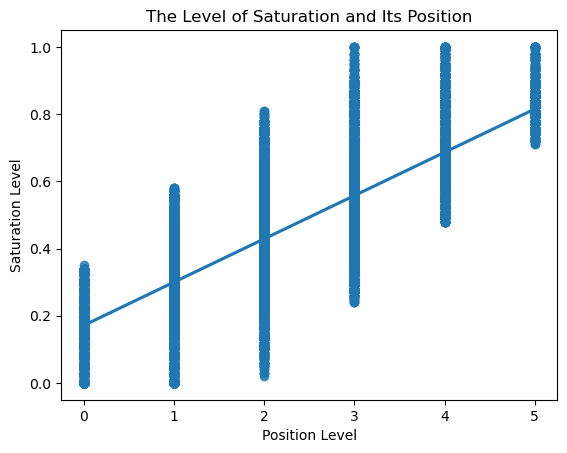

In [95]:
# syntax untuk visualisasi scatterplot dengan seaborn

sns.regplot(x=df_train["Designation"], y=df_train["Burn Rate"])
plt.ylabel('Saturation Level')
plt.xlabel('Position Level')
plt.title('The Level of Saturation and Its Position')

Based on this scatterplot, there appears to be a linear correlation between the level of burnout and job designation. The significance of this visualization is that as the job designation rises, the level of burnout also tends to increase. Conversely, lower job designations correspond to lower levels of burnout. However, at the same job designation level, each employee exhibits their own level of burnout, as depicted in the plot above.

## Comparison of the Number of Employee Genders

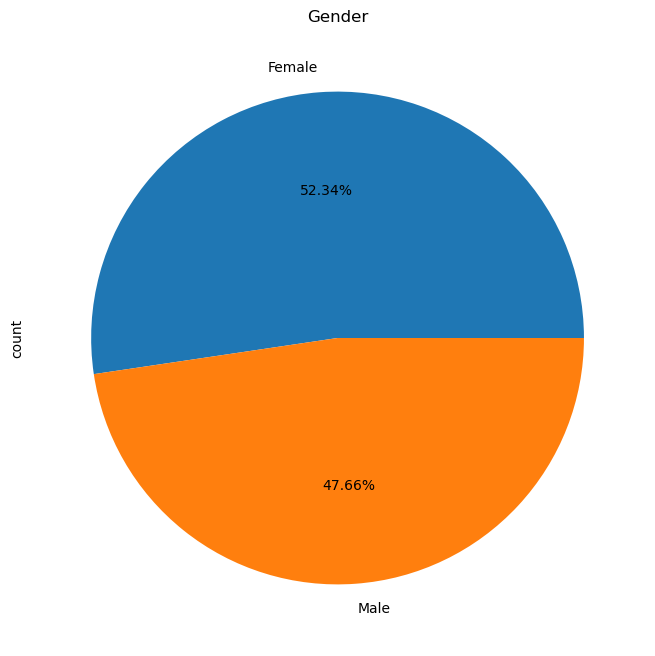

In [96]:
#syntax to display the Gender Number comparison
fig,ax1 = plt.subplots(figsize=(8,8))

df_train['Gender'].value_counts().plot(kind='pie', autopct='%.2f%%',ax=ax1)
plt.title('Gender')
plt.show()


From the visualization above, it can be seen that the percentage of women reached 52.34%, while men only reached 47.66%. This shows that the number of women is greater than the number of men in the observed dataset.

## Comparison of Number of Company Types of Employees

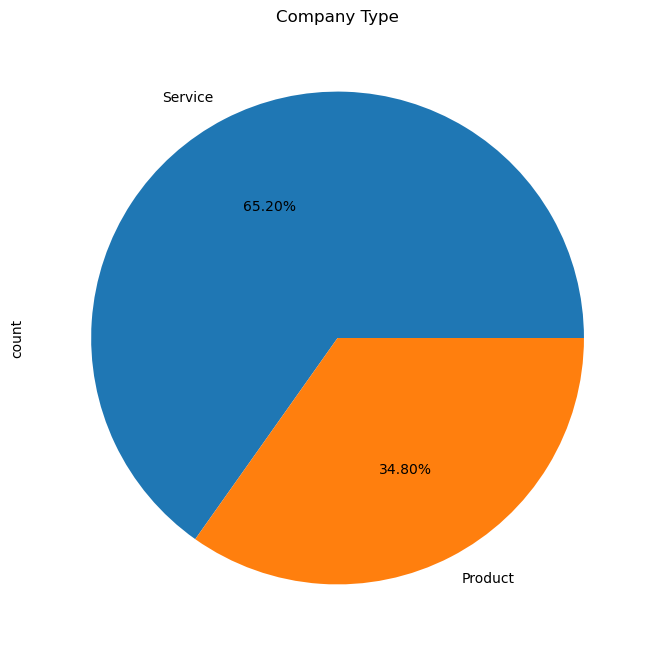

In [97]:
#syntax to display the Gender Number comparison
fig,ax1 = plt.subplots(figsize=(8,8))

df_train['Company Type'].value_counts().plot(kind='pie', autopct='%.2f%%',ax=ax1)
plt.title('Company Type')
plt.show()

Based on the visualization displayed, employees who work in the service sector reach 65.20% and employees who work in the product sector reach 34.80%. This means that many employees work in the service sector in the product production sector in this dataset.

## Comparison of the Number of People Allowed to WFH

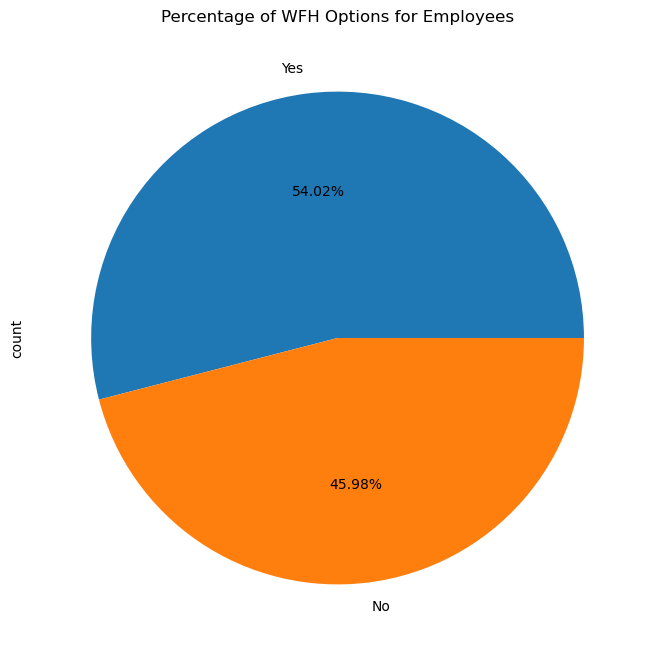

In [98]:
#syntax to display the Gender Number comparison
fig,ax1 = plt.subplots(figsize=(8,8))

df_train['WFH Setup Available'].value_counts().plot(kind='pie', autopct='%.2f%%',ax=ax1)
plt.title('Percentage of WFH Options for Employees')
plt.show()

From the visualization presented, it can be seen that 54.02% of employees in the dataset are permitted to work from home (WFH), while 45.98% of employees are not permitted to work from home (WFO). This shows that the majority of employees in the dataset have access to work from home, indicating widespread adoption of remote working (WFH) flexibility.

## Correlation between Number of Working Hours, Position Level, Stress Score, and Fatigue Level

Text(0.5, 1.0, 'Heatmap between Number of working hours, Position Level, Stress Score, and Fatigue Level')

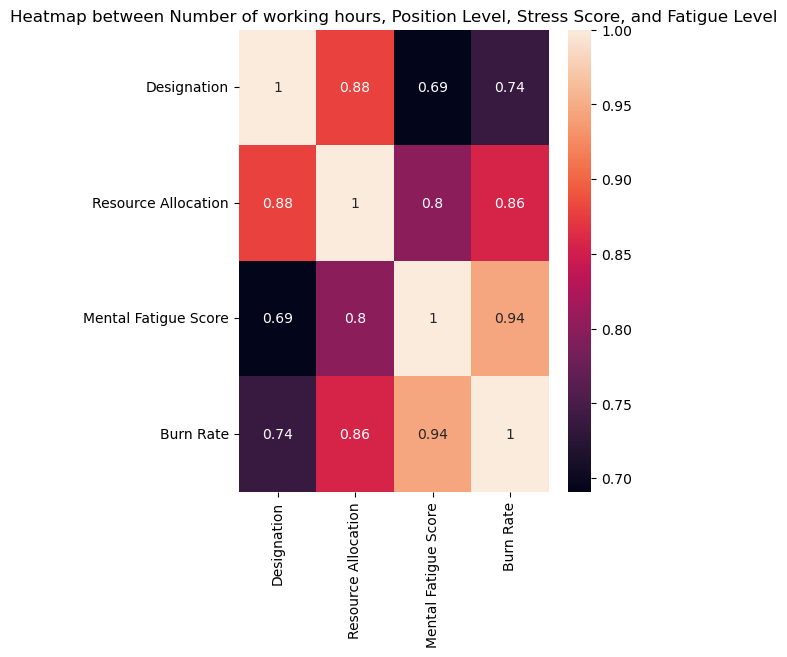

In [99]:
fig, axes = plt.subplots( figsize=(5, 6))

sns.heatmap(df_train[['Designation', 'Resource Allocation',
        'Mental Fatigue Score', 'Burn Rate']].corr(),annot=True)
plt.title('Heatmap between Number of working hours, Position Level, Stress Score, and Fatigue Level')

Based on the heatmap visualization which depicts the correlation between columns using the Spearman method, the resource allocation column (number of working hours), the mental fatigue score column (stress level) has a strong correlation with the burn rate (burn out) level.

# Feature Engineering

## Handling cardinality

In [100]:
#to display unique values from categorical (and numeric) columns
cat = (df_train.select_dtypes(include=['object','datetime64']).columns)

listItem = []
for col in cat:
  listItem.append([col, df_train[col].nunique()])

pd.DataFrame(columns=['column name', 'number of unique values'], data=listItem)

,column name,number of unique values
0,Employee ID,22750
1,Date of Joining,366
2,Gender,2
3,Company Type,2
4,WFH Setup Available,2


Based on calculations, results were obtained for high and low cardinality.  
High cardinality = Employee ID and date of joining  
low cardinality = Gender, Company Type, and WFH Setup Available  

__Must Do!__
For data with low cardinality, encoding can be done, for high cardinality data it must first be checked to see whether it is correlated with the target.

## Split X dan Y

The target we want to know is the burn out level of employees so that  
Y = burn rate column

In [35]:
#separation of features and targets
X = df_train.drop(['Burn Rate'], axis = 1)
y = df_train['Burn Rate']

In [36]:
#separation between train dataset and test dataset.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 30)
print('Train Size: ', X_train.shape)
print('Test Size: ', X_test.shape)

Train Size:  (17062, 8)
Test Size:  (5688, 8)


This model uses 65%/414684 data for training from the dataset and will be tested with 25%/5688 data. why use this comparison to reduce the possibility of overfitting and lowfitting models.

## Handling Outlier

In [102]:
#syntax to find out the skew value and type of skewness
num_cols = list(X_train.select_dtypes(exclude=['object','datetime64']).columns)


kolom = []
skewnes = []
skews = []

for col in num_cols:
  skew = X_train[col].skew()
  kolom.append(col)

  if skew >= -0.5 and skew <= 0.5:
    skewnes.append('normal')
  else:
    skewnes.append('skew')
  skews.append(skew)

kolskew = pd.DataFrame({'column name' : kolom , 'skewness' : skewnes,'skewness value':skew })
kolskew


,column name,skewness,skewness value
0,Designation,normal,-0.43056
1,Resource Allocation,normal,-0.43056
2,Mental Fatigue Score,normal,-0.43056


Below is a column that groups skewed and normal data. The distribution is skewed or normal, determined from a skew value that is greater than 0.5 or smaller than -0.5, then the value is skewed. Below this value can be called normal distribution. Based on the calculations above, there is no skew in the data for the numerical column. All data tends to have a normal distribution.

In [38]:
#normal column grouping
normal = list(kolskew[kolskew['skewness']== "normal"]['nama_kolom'])


### Proses Capping dengan Winsorizer

__Winsorizer untuk persebaran normal__

In [39]:
#syntax for handling outliers by capping using winsorizer for gaussian capping method

winsorisernorm = Winsorizer(capping_method='gaussian',
                            tail='both',
                            fold=3,
                            variables= normal,
                            missing_values='ignore')

X_train_capped = winsorisernorm.fit_transform(X_train)
X_test_capped = winsorisernorm.transform(X_test)

Columns with normal distribution have been successfully capped.

Designation - Before Capping


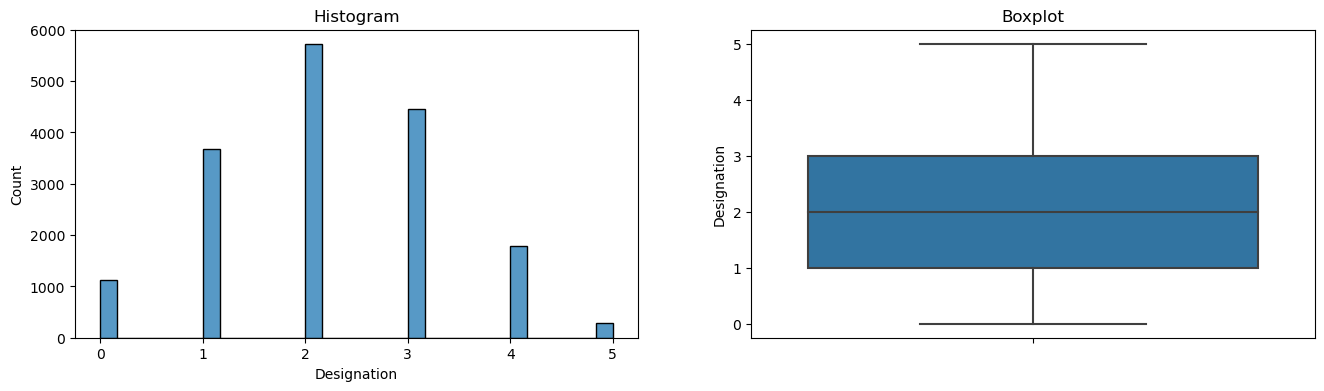


Designation - After Capping


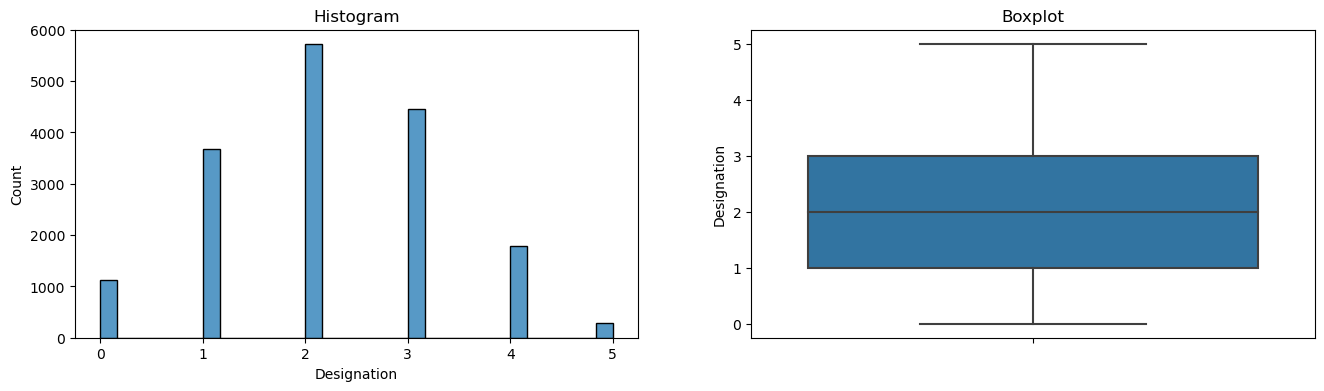

Resource Allocation - Before Capping


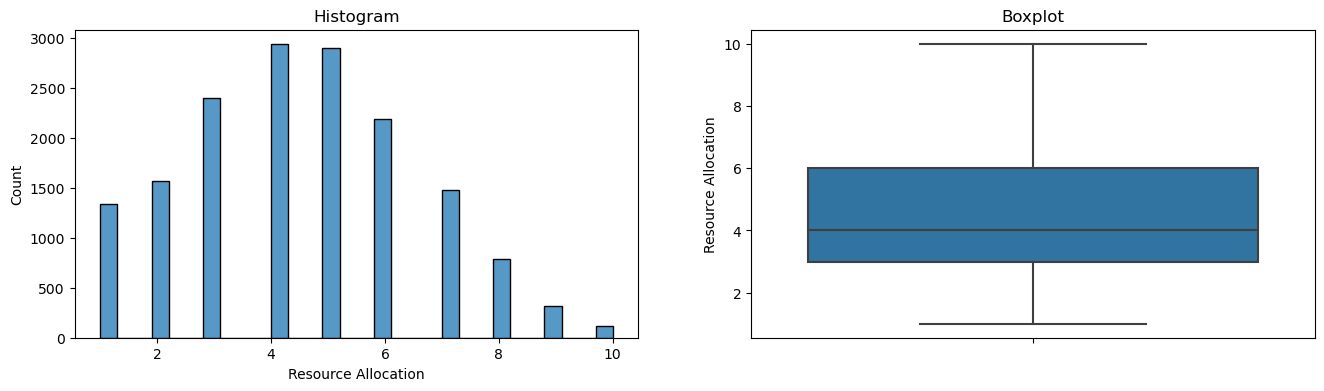


Resource Allocation - After Capping


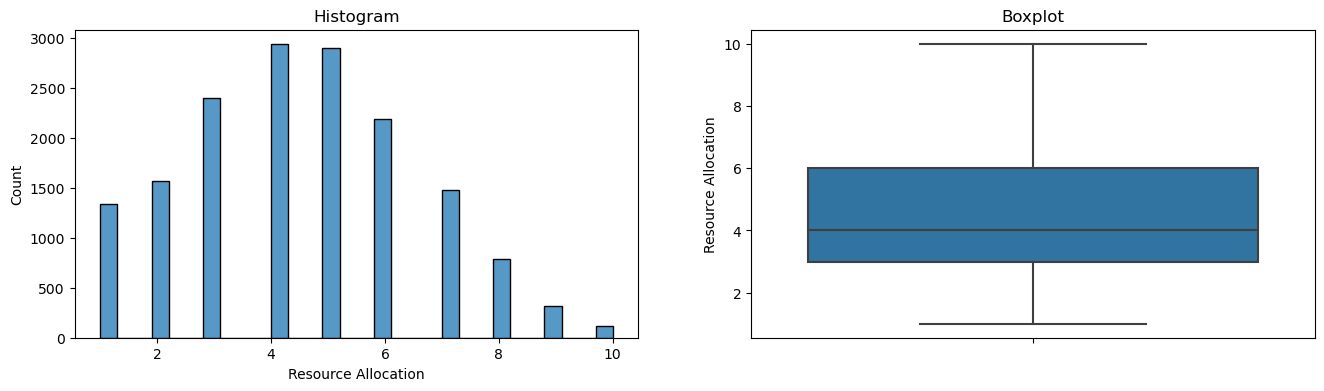

Mental Fatigue Score - Before Capping


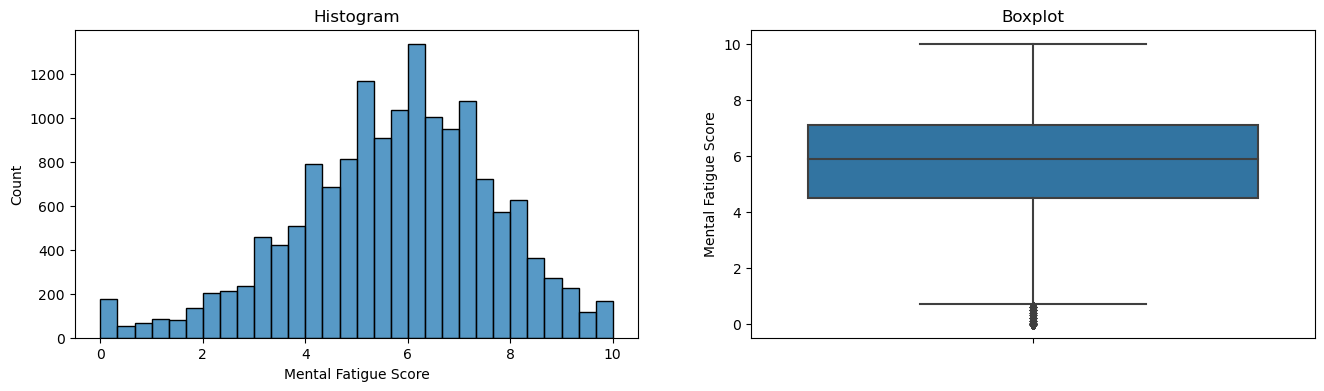


Mental Fatigue Score - After Capping


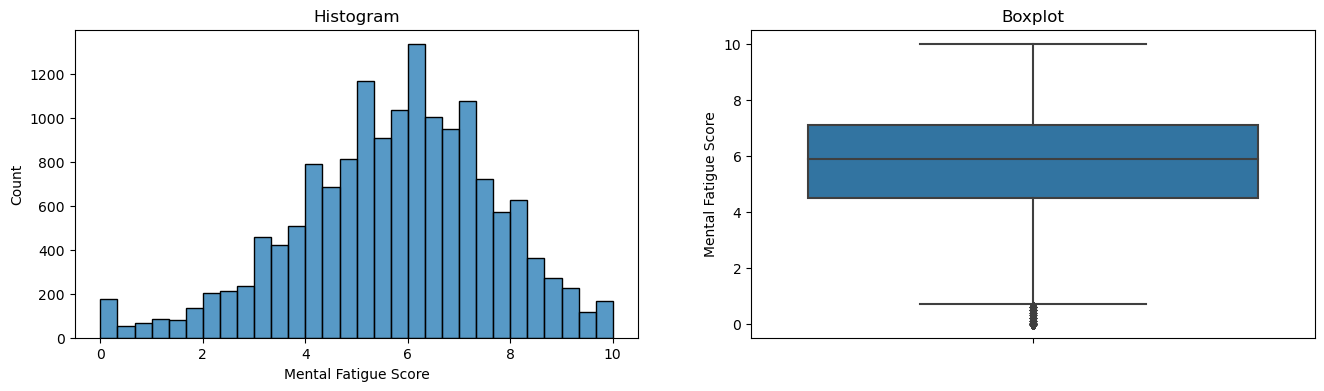

In [40]:
# Function to display histograms and boxplots from columns.
def diagnostic_plots(df, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()


for col in num_cols:
  print(f'{col} - Before Capping')
  diagnostic_plots(X_train, col)

  print(f'\n{col} - After Capping')
  diagnostic_plots(X_train_capped, col)

Based on the capping results, the mental fatigue score column does not change based on the capping results. capping will be carried out using the IQR method

In [41]:
ske = ['Mental Fatigue Score']

In [42]:
# syntax for handling outliers by capping using winsorizer for the IQR capping method

winsoriserskew = Winsorizer(capping_method='iqr',
                            tail='both',
                            fold=1.5,
                            variables= ske,
                            missing_values='ignore')

X_train_capped = winsoriserskew.fit_transform(X_train_capped)
X_test_capped = winsorisernorm.transform(X_test_capped)

The capping process was successfully carried out

Mental Fatigue Score - Before Capping


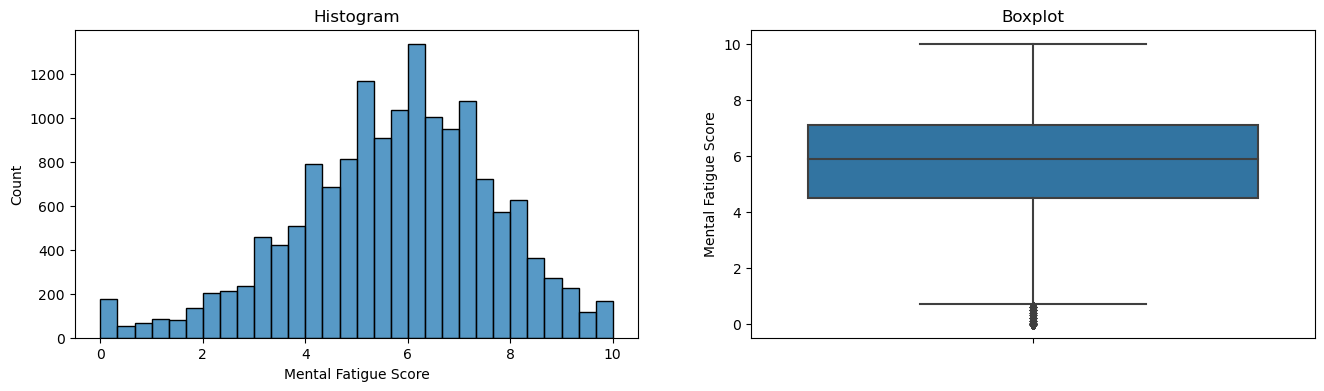

Mental Fatigue Score - After Capping


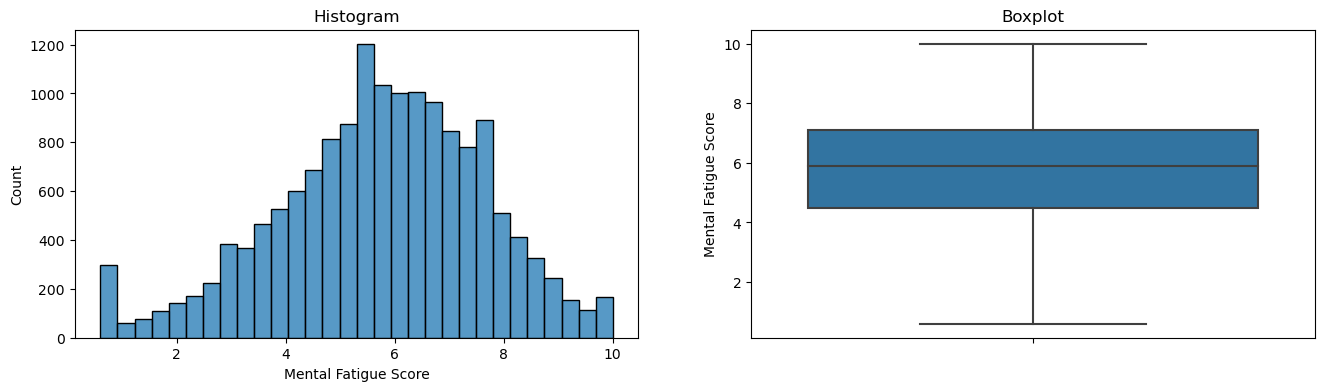

In [43]:
# Function to display histograms and boxplots from columns.
def diagnostic_plots(df, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()



print(f'Mental Fatigue Score - Before Capping')
diagnostic_plots(X_train, 'Mental Fatigue Score')

print(f'Mental Fatigue Score - After Capping')
diagnostic_plots(X_train_capped, 'Mental Fatigue Score')

semua data sudah terhandle outliernya, selanjutnya adalah handling missing value

## Handling Missing Value

In [44]:
#displays the number of missing values in the train data.

print("Null di X_train",X_train_capped.isnull().sum())


Null di X_train Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1035
Mental Fatigue Score    1598
dtype: int64


There are outliers in the resource allocation and mental fatigue score columns

In [45]:
#displays the number of missing values in the test data.

print("Null di X_test",X_test_capped.isnull().sum())


Null di X_test Employee ID               0
Date of Joining           0
Gender                    0
Company Type              0
WFH Setup Available       0
Designation               0
Resource Allocation     346
Mental Fatigue Score    519
dtype: int64


There are outliers in the resource allocation and mental fatigue score columns

In [46]:
#displays the number of missing values in the y train and test data.

print("Null di y_train",y_train.isnull().sum())
print("Null di y_test",y_test.isnull().sum())


Null di y_train 842
Null di y_test 282


There are outliers in the burn rate column or target column.

In [47]:
# Count How Many Observations that We Would Drop

handleMisval = df_train.copy()
print('Total passengers in the Titanic               : ', handleMisval.shape[0])
print('Total passengers with values in all variables : ', handleMisval.dropna().shape[0])
print('Percentage of data without missing values (%) : ', handleMisval.dropna().shape[0] / handleMisval.shape[0] * 100)

Total passengers in the Titanic               :  22750
Total passengers with values in all variables :  18590
Percentage of data without missing values (%) :  81.71428571428572


Null data contained in the target/y_train/y_test column must not be handled and must be trimmed/dropped so as not to produce biased data.

In [48]:
#store the target data index which is null

nulYtrain = y_train[y_train.isnull()].index.tolist()
nulYtest = y_test[y_test.isnull()].index.tolist()

In [49]:
#drop null data on the target and drop the same row on the X train and test data


X_train_capped = X_train_capped.drop(index=nulYtrain)
X_test_capped = X_test_capped.drop(index=nulYtest)

y_train.dropna(inplace=True)
y_test.dropna(inplace=True)


The target column has had its nulls removed. The next step is to handle outliers in data X.

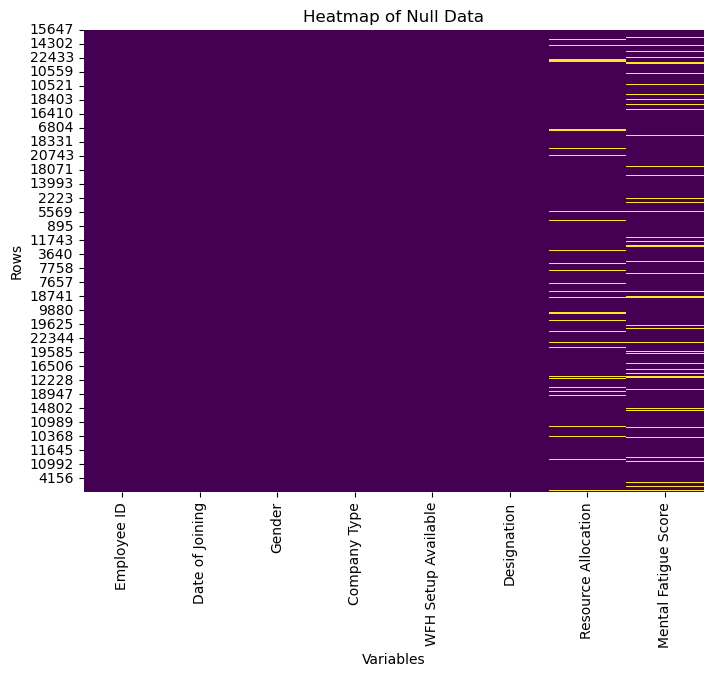

In [50]:
#Checking the distribution of outlier data using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(X_train_capped.isnull(), cmap='viridis', cbar=False)
plt.title('Heatmap of Null Data')
plt.xlabel('Variables')
plt.ylabel('Rows')
plt.show()

In [51]:
#Display null data in the Resource Allocation column
X_train_capped[X_train_capped['Resource Allocation'].isna()].head(50)

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score
2513,fffe32003200340031003100,2008-04-06,Female,Service,Yes,1.0,NaN,4.5
13435,fffe31003200330034003600,2008-08-27,Male,Service,Yes,2.0,NaN,4.5
11169,fffe3600310038003400,2008-04-28,Female,Product,Yes,2.0,NaN,7.1
10752,fffe31003300370036003100,2008-10-29,Female,Product,No,3.0,NaN,NaN
15389,fffe31003200360032003600,2008-05-02,Male,Product,Yes,2.0,NaN,7.9
1810,fffe3400310032003500,2008-02-17,Male,Service,Yes,3.0,NaN,7.4
7476,fffe32003100350032003900,2008-09-07,Female,Product,Yes,3.0,NaN,6.2
3310,fffe31003600390035003900,2008-01-01,Female,Service,Yes,2.0,NaN,4.7
14194,fffe31003900330034003300,2008-09-30,Male,Service,No,4.0,NaN,8.5
17596,fffe3700390033003500,2008-03-18,Male,Service,Yes,2.0,NaN,NaN


In [52]:
# Missing Value Calculation

handleMisval = df_train.copy()
print('Total Data                                   : ', handleMisval['Resource Allocation'].shape[0])
print('Total Data tanpa Missing Value                : ', handleMisval['Resource Allocation'].dropna().shape[0])
print('Percentage of data without missing values (%) : ', handleMisval['Resource Allocation'].dropna().shape[0] / handleMisval['Resource Allocation'].shape[0] * 100)

Total Data                                   :  22750
Total Data tanpa Missing Value                :  21369
Percentage of data without missing values (%) :  93.92967032967033


There are 7% data with missing values in the Resource Allocation column

In [53]:
#Displays null data in the Mental Fatigue Score column

X_train_capped[X_train_capped['Mental Fatigue Score'].isna()].head(50)


,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score
5036,fffe31003900390037003600,2008-09-25,Female,Product,No,3.0,7.0,NaN
7799,fffe3200340030003800,2008-03-10,Female,Service,Yes,1.0,3.0,NaN
10441,fffe31003300360039003900,2008-06-18,Male,Service,No,2.0,4.0,NaN
17461,fffe31003600390039003600,2008-12-10,Female,Product,Yes,1.0,1.0,NaN
21908,fffe3900330036003400,2008-06-10,Female,Product,Yes,3.0,7.0,NaN
19346,fffe3600360037003800,2008-01-28,Female,Service,Yes,3.0,4.0,NaN
13716,fffe3700370032003400,2008-08-06,Female,Service,Yes,1.0,1.0,NaN
4791,fffe32003200350030003800,2008-03-12,Female,Service,No,3.0,6.0,NaN
3036,fffe31003600380033003900,2008-01-21,Male,Service,Yes,1.0,2.0,NaN
20986,fffe31003900350031003000,2008-01-06,Male,Product,No,0.0,2.0,NaN


In [54]:
# Missing Value Calculation

handleMisval = df_train.copy()
print('Total Data                                   : ', handleMisval['Mental Fatigue Score'].shape[0])
print('Total Data tanpa Missing Value                : ', handleMisval['Mental Fatigue Score'].dropna().shape[0])
print('Percentage of data without missing values (%) : ', handleMisval['Mental Fatigue Score'].dropna().shape[0] / handleMisval['Resource Allocation'].shape[0] * 100)

Total Data                                   :  22750
Total Data tanpa Missing Value                :  20633
Percentage of data without missing values (%) :  90.69450549450549


Terdapat 7% data yang missing value pada kolom Mental Fatigue Score

Berdasarkan pengamatan, missing value merupakan missing completely at random karena tidak ada alasan mengapa sejumlah data tersebut tidak ada. Tidak dilakukan imputasi untuk menjaga hasil yang diberikan sesuai dengan kondisi yang terjadi di Lapangan.

In [55]:
#store the target data index which is null

nulXtrain = X_train_capped[X_train_capped.isnull().any(axis=1)].index.tolist()
nulXtest = X_test_capped[X_test_capped.isnull().any(axis=1)].index.tolist()



In [56]:
#drop on Y based on the null data index on data X
y_train = y_train.drop(index=nulXtrain)
y_test = y_test.drop(index=nulXtest)


In [57]:
#drop missing values in data X
X_train_capped = X_train_capped.drop(index=nulXtrain)
X_test_capped = X_test_capped.drop(index=nulXtest)

In [58]:
#display the shape of the X train data
X_train_capped.shape

(13936, 8)

In [59]:
#display the shape of the X test data

X_test_capped.shape

(4654, 8)

In [60]:
#displays the shape of the Y train data

y_train.shape


(13936,)

In [61]:
#displays the shape of the Y test data

y_test.shape


(4654,)

The data matches the rows and columns. there is no error in drop row.

## Feature Selection

In [62]:
#group categorical columns
cat_columns = ['Employee ID',
 'Date of Joining',
 'Gender',
 'Company Type',
 'WFH Setup Available']

In [63]:
#group numerical columns

num_cols = ['Designation', 'Resource Allocation', 'Mental Fatigue Score']

In [103]:
#syntax for calculating categorical column correlation using the kendalltau method

p_values = []
interpretasi = []
cols = []
corr = []


for col in cat_columns:
  corr_coef, p_value = kendalltau(X_train_capped[col], y_train)

  p_values.append(p_value)
  cols.append(col)
  corr.append(corr_coef)

  if p_value < 0.05:
    interpretasi.append('ada korelasi')
  else :
    interpretasi.append('ga ada korelasi')

pd.DataFrame({'column name':cols,
               'result': interpretasi,
               'pvalue':p_values,
               'Corr Value' : corr })

,column name,result,pvalue,Corr Value
0,Employee ID,ga ada korelasi,4.545705e-01,0.004254
1,Date of Joining,ga ada korelasi,2.429877e-01,0.006650
2,Gender,ada korelasi,5.224362e-90,0.140135
3,Company Type,ga ada korelasi,9.324905e-01,-0.000590
4,WFH Setup Available,ada korelasi,0.000000e+00,-0.273360


Column __['Gender','WFH Setup Available']__ has a correlation with the target column (Burn Rate)

In [104]:
#syntax to calculate numerical column correlation using the pearsonr method

p_values = []
interpretasi = []
cols = []
corr = []

for col in num_cols:
  corr_coef, p_value = pearsonr(X_train_capped[col], y_train)

  p_values.append(p_value)
  cols.append(col)
  corr.append(corr_coef)

  if p_value < 0.05:
    interpretasi.append('ada korelasi')
  else :
    interpretasi.append('ga ada korelasi')

pd.DataFrame({'column name':cols,
               'result': interpretasi,
               'pvalue':p_values,
               'Corr Value' : corr })

,column name,result,pvalue,Corr Value
0,Designation,ada korelasi,0.0,0.733975
1,Resource Allocation,ada korelasi,0.0,0.853297
2,Mental Fatigue Score,ada korelasi,0.0,0.946032


All numerical columns have a correlation with the target (Burn Rate)

__Result__  
Columns that have a correlation with the target will become features in the model.

## Encoding and Scaling

__Definition of ColumnTransformer__

In [66]:
#Assign ColumnTransformer to perform scaling and encoding on columns that have been determined in feature engineering
#Scaling using standardscaler and encoding using onehotencoder
prep = ColumnTransformer([
    ('scaler', StandardScaler(), [ 'Designation', 'Resource Allocation','Mental Fatigue Score']),
    ('encoding', OneHotEncoder(),['Gender','WFH Setup Available'])])       

prep

ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                 ['Designation', 'Resource Allocation',
                                  'Mental Fatigue Score']),
                                ('encoding', OneHotEncoder(),
                                 ['Gender', 'WFH Setup Available'])])

ColumnTransformer has been successfully assigned

# Machine Learning

## Model Definition

KNN SVM Decision tree, random forest, boosting

In this notebook, 5 algorithm models will be used to predict burn rate values. These results will be compared and the best result will be hyperparameter tuning.
The model used is:
- K-NearestRegressor
- Support Vector Regressor
- Decision Tree Regressors
- Random Forest Regressor
- LightGBM Regressor

In [67]:
#Model Definition K-NearestRegressor
pipe_knn = Pipeline([
('transformer', prep),
('classifier', KNeighborsRegressor())
])


#Model Definition Support Vector Regressor
pipe_svr = Pipeline([
('transformer', prep),
('classifier', SVR())
])

#Model Definition Decision Tree Regressor
pipe_tree = Pipeline([
('transformer', prep),
('classifier', DecisionTreeRegressor())
])

#Model Definition Random Forest Regressor
pipe_rf = Pipeline([
('transformer', prep),
('classifier', RandomForestRegressor())
])

#Model Definition LightGBM Regressor
pipe_lgb = Pipeline([
('transformer', prep),
('classifier', LGBMRegressor(verbose=-1))
])



## Model K-NearestRegressor

In [68]:
#the model is fitted to the train data
pipe_knn.fit(X_train_capped, y_train)

#the model learns X test data
y_knn_pred_train = pipe_knn.predict(X_train_capped)
y_knn_pred_test = pipe_knn.predict(X_test_capped)

In [69]:
##Displays the error from the model using mean absolute error, root mean squared error, and r2 score.

print('Error - train set MAE: ', mean_absolute_error(y_train, y_knn_pred_train))
print('Error - Test Set MAE : ', mean_absolute_error(y_test, y_knn_pred_test))
print("-----")
print('Error - train set RMSE: ', mean_squared_error(y_train, y_knn_pred_train,squared=False))
print('Error - Test Set RMSE : ', mean_squared_error(y_test, y_knn_pred_test,squared=False))
print("-----")
print('Nilai R2 score - train set : ', r2_score(y_train, y_knn_pred_train))
print('Nilai R2 score  - Test Set r2 : ', r2_score(y_test, y_knn_pred_test))

Error - train set MAE:  0.039558553386911596
Error - Test Set MAE :  0.04599140524280189
-----
Error - train set RMSE:  0.05026267968384841
Error - Test Set RMSE :  0.05781913919937557
-----
Nilai R2 score - train set :  0.9350754743803847
Nilai R2 score  - Test Set r2 :  0.91605073767251


Based on the testing results, the K-Nearest Regressor (KNR) model has a Mean Absolute Error (MAE) of 0.039558553386911596 on the training set and 0.04599140524280189 on the test set. The Root Mean Squared Error (RMSE) is 0.05026267968384841 on the training set and 0.05781913919937557 on the test set. These results are considered quite good given the target column's range, which is from 0 to 1. Therefore, having an error of 0.05 indicates that the model's predicted values are within the range of ±0.05 from the actual values.

There is a 2% difference in the R-squared score between the training set and test set. To further evaluate the model's performance, cross-validation will be conducted.

In [70]:
#Cross Validation

r2_train_cross_val = cross_val_score(pipe_knn,
                                     X_train_capped,
                                     y_train,
                                     cv=10,
                                     scoring="r2")

print('r2 Score - All - Cross Validation  : ', r2_train_cross_val)
print('r2 Score - Mean - Cross Validation : ', r2_train_cross_val.mean())
print('r2 Score - Std - Cross Validation  : ', r2_train_cross_val.std())
print('r2 Score - Range of Test-Set       : ', (r2_train_cross_val.mean()-r2_train_cross_val.std()) , '-', (r2_train_cross_val.mean()+r2_train_cross_val.std()))

r2 Score - All - Cross Validation  :  [0.91513836 0.92410141 0.91314846 0.91571158 0.91481146 0.91776652
 0.91139583 0.90944189 0.92176069 0.91251206]
r2 Score - Mean - Cross Validation :  0.915578825547321
r2 Score - Std - Cross Validation  :  0.004323280365705284
r2 Score - Range of Test-Set       :  0.9112555451816157 - 0.9199021059130262


Based on the results of cross validation for 10 iterations, the average r2 score is 91.55% with a standard deviation of 0.004. This means that this model has r2 score results that are not much different at each iteration. The average r2 score is also very good at 91.55%.

## Model Support Vector Regressor

In [71]:
#the model is fitted to the train data
pipe_svr.fit(X_train_capped, y_train)

#the model learns X test data
y_svr_pred_train = pipe_svr.predict(X_train_capped)
y_svr_pred_test = pipe_svr.predict(X_test_capped)


In [72]:
#Displays the error from the model using mean absolute error, root mean squared error, and r2 score.

print('Error - train set MAE: ', mean_absolute_error(y_train, y_svr_pred_train))
print('Error - Test Set MAE : ', mean_absolute_error(y_test, y_svr_pred_test))
print("-----")
print('Error - train set RMSE: ', mean_squared_error(y_train, y_svr_pred_train,squared=False))
print('Error - Test Set RMSE : ', mean_squared_error(y_test, y_svr_pred_test,squared=False))
print("-----")
print('Nilai R2 score - train set : ', r2_score(y_train, y_svr_pred_train))
print('Nilai R2 score  - Test Set r2 : ', r2_score(y_test, y_svr_pred_test))

Error - train set MAE:  0.04947214978152263
Error - Test Set MAE :  0.050104126701479575
-----
Error - train set RMSE:  0.05813748538418637
Error - Test Set RMSE :  0.059191624181536166
-----
Nilai R2 score - train set :  0.9131379660735124
Nilai R2 score  - Test Set r2 :  0.9120179342343805


Based on the testing results, the Support Vector Regressor (SVR) model has a Mean Absolute Error (MAE) of 0.04947214978152263 on the training set and 0.050104126701479575 on the test set. The Root Mean Squared Error (RMSE) is 0.05813748538418637 on the training set and 0.059191624181536166 on the test set. These results are considered quite good given the target column's range, which is from 0 to 1. Therefore, having an error of 0.059 indicates that the model's predicted values are within the range of ±0.059 from the actual values.

The R-squared score results for the training set and test set are relatively similar, both at 91%. To further evaluate the model's performance, cross-validation will be conducted.

In [73]:
#Cross Validation

r2_train_cross_val = cross_val_score(pipe_svr,
                                     X_train_capped,
                                     y_train,
                                     cv=10,
                                     scoring="r2")

print('r2 Score - All - Cross Validation  : ', r2_train_cross_val)
print('r2 Score - Mean - Cross Validation : ', r2_train_cross_val.mean())
print('r2 Score - Std - Cross Validation  : ', r2_train_cross_val.std())
print('r2 Score - Range of Test-Set       : ', (r2_train_cross_val.mean()-r2_train_cross_val.std()) , '-', (r2_train_cross_val.mean()+r2_train_cross_val.std()))

r2 Score - All - Cross Validation  :  [0.91326248 0.9175422  0.91090749 0.90962359 0.91237109 0.91358816
 0.91281051 0.90759543 0.91803591 0.91017688]
r2 Score - Mean - Cross Validation :  0.9125913739010606
r2 Score - Std - Cross Validation  :  0.0031325163089218596
r2 Score - Range of Test-Set       :  0.9094588575921387 - 0.9157238902099825


Based on the results of cross validation for 10 iterations, the average r2 score is 91.25% with a standard deviation of 0.003. This means that this model has r2 score results that are not much different at each iteration. The average r2 score results are also very good at 91.55%.

## Model Decision Tree Regressor

In [74]:
#model is fitted to train data
pipe_tree.fit(X_train_capped, y_train)

#model learns X test data
y_tree_pred_train = pipe_tree.predict(X_train_capped)
y_tree_pred_test = pipe_tree.predict(X_test_capped)


In [75]:
#Displays the error from the model using the mean absolute error and r2 score.

print('Error - train set MAE: ', mean_absolute_error(y_train, y_tree_pred_train))
print('Error - Test Set MAE : ', mean_absolute_error(y_test, y_tree_pred_test))
print("-----")
print('Error - train set RMSE: ', mean_squared_error(y_train, y_tree_pred_train,squared=False))
print('Error - Test Set RMSE : ', mean_squared_error(y_test, y_tree_pred_test,squared=False))
print("-----")
print('Nilai R2 score - train set : ', r2_score(y_train, y_tree_pred_train))
print('Nilai R2 score  - Test Set r2 : ', r2_score(y_test, y_tree_pred_test))

Error - train set MAE:  0.03560471403979034
Error - Test Set MAE :  0.04618767229482515
-----
Error - train set RMSE:  0.04648021977243788
Error - Test Set RMSE :  0.05838007155688696
-----
Nilai R2 score - train set :  0.9444794380130545
Nilai R2 score  - Test Set r2 :  0.9144139689692022


Based on the testing results, the Decision Tree Regressor model has a Mean Absolute Error (MAE) of 0.03560471403979034 on the training set and 0.046199669143414175 on the test set. The Root Mean Squared Error (RMSE) is 0.04648021977243788 on the training set and 0.05840283904726611 on the test set. These results are considered very good given the target column's range, which is from 0 to 1. Therefore, having an error of 0.054 indicates that the model's predicted values are within the range of ±0.058 from the actual values.

There is a 3% difference in the R-squared score results between the training set and test set. To further evaluate the model's performance, cross-validation will be conducted.

In [76]:
#Cross Validation

r2_train_cross_val = cross_val_score(pipe_tree,
                                     X_train_capped,
                                     y_train,
                                     cv=10,
                                     scoring="r2")

print('r2 Score - All - Cross Validation  : ', r2_train_cross_val)
print('r2 Score - Mean - Cross Validation : ', r2_train_cross_val.mean())
print('r2 Score - Std - Cross Validation  : ', r2_train_cross_val.std())
print('r2 Score - Range of Test-Set       : ', (r2_train_cross_val.mean()-r2_train_cross_val.std()) , '-', (r2_train_cross_val.mean()+r2_train_cross_val.std()))

r2 Score - All - Cross Validation  :  [0.90660384 0.91761698 0.90832917 0.90971075 0.9098005  0.91079329
 0.90770409 0.90523724 0.91675238 0.91056639]
r2 Score - Mean - Cross Validation :  0.9103114642861966
r2 Score - Std - Cross Validation  :  0.0038209563551780787
r2 Score - Range of Test-Set       :  0.9064905079310185 - 0.9141324206413747


Based on the results of cross validation for 10 iterations, the average r2 score is 91.01% with a standard deviation of 0.003. This means that this model has r2 score results that are not much different at each iteration. The average r2 score is also very good at 91.04%.

## Model Random Forest Regressor

In [77]:
#model is fitted to train data
pipe_rf.fit(X_train_capped, y_train)

#model learns X test data
y_rf_pred_train = pipe_rf.predict(X_train_capped)
y_rf_pred_test = pipe_rf.predict(X_test_capped)


In [78]:
#Displays the error from the model using the mean absolute error and r2 score.

print('Error - train set MAE: ', mean_absolute_error(y_train, y_rf_pred_train))
print('Error - Test Set MAE : ', mean_absolute_error(y_test, y_rf_pred_test))
print("-----")
print('Error - train set RMSE: ', mean_squared_error(y_train, y_rf_pred_train,squared=False))
print('Error - Test Set RMSE : ', mean_squared_error(y_test, y_rf_pred_test,squared=False))
print("-----")
print('Nilai R2 score - train set : ', r2_score(y_train, y_rf_pred_train))
print('Nilai R2 score  - Test Set r2 : ', r2_score(y_test, y_rf_pred_test))

Error - train set MAE:  0.03655624956635718
Error - Test Set MAE :  0.04524039708015309
-----
Error - train set RMSE:  0.04676031031567298
Error - Test Set RMSE :  0.05684797196859875
-----
Nilai R2 score - train set :  0.9438082863239743
Nilai R2 score  - Test Set r2 :  0.9188471842832042


Based on the test results, the Random Forest Regressor model has a MAE error in train of 0.03656979522374799 and in test of 0.04511368736352564, RMSE error in train of 0.046764372765509196 and test of 0.05674823433839227. These results are very good if seen from the range of the target column, namely from 0 to 1, so that if it has an error of 0.056, it means that the prediction results produced by the model have actual values in the range -0.056 and +0.056.

There is a 3% difference in the r2 score results in the train set and test set. To find out further model performance, cross validation will be carried out.

In [79]:
#Cross Validation Model Ini

r2_train_cross_val = cross_val_score(pipe_rf,
                                     X_train_capped,
                                     y_train,
                                     cv=10,
                                     scoring="r2")

print('r2 Score - All - Cross Validation  : ', r2_train_cross_val)
print('r2 Score - Mean - Cross Validation : ', r2_train_cross_val.mean())
print('r2 Score - Std - Cross Validation  : ', r2_train_cross_val.std())
print('r2 Score - Range of Test-Set       : ', (r2_train_cross_val.mean()-r2_train_cross_val.std()) , '-', (r2_train_cross_val.mean()+r2_train_cross_val.std()))

r2 Score - All - Cross Validation  :  [0.91375652 0.92189926 0.91500817 0.91620852 0.91544855 0.91716989
 0.91448521 0.91203806 0.92248447 0.91561077]
r2 Score - Mean - Cross Validation :  0.9164109419176624
r2 Score - Std - Cross Validation  :  0.0031786314275170646
r2 Score - Range of Test-Set       :  0.9132323104901453 - 0.9195895733451794


Based on the results of cross validation for 10 iterations, the average r2 score is 91.64% with a standard deviation of 0.003. This means that this model has r2 score results that are not much different at each iteration. The average r2 score is also very good at 91.64%.

## Model LightGBM

In [80]:
#model is fitted to train data
pipe_lgb.fit(X_train_capped, y_train)

#model learns X test data
y_lgb_pred_train = pipe_lgb.predict(X_train_capped)
y_lgb_pred_test = pipe_lgb.predict(X_test_capped)


In [81]:
#Displays the error from the model using the mean absolute error and r2 score.
print('Error - train set MAE: ', mean_absolute_error(y_train, y_lgb_pred_train))
print('Error - Test Set MAE : ', mean_absolute_error(y_test, y_lgb_pred_test))
print("-----")
print('Error - train set RMSE: ', mean_squared_error(y_train, y_lgb_pred_train,squared=False))
print('Error - Test Set RMSE : ', mean_squared_error(y_test, y_lgb_pred_test,squared=False))
print("-----")
print('Nilai R2 score - train set : ', r2_score(y_train, y_lgb_pred_train))
print('Nilai R2 score  - Test Set r2 : ', r2_score(y_test, y_lgb_pred_test))

Error - train set MAE:  0.041366541981782086
Error - Test Set MAE :  0.04283215297440664
-----
Error - train set RMSE:  0.05096948216444195
Error - Test Set RMSE :  0.052975310496332216
-----
Nilai R2 score - train set :  0.9332366761199101
Nilai R2 score  - Test Set r2 :  0.9295273402726404


Based on the testing results, the LightGBM model has a Mean Absolute Error (MAE) of 0.041366541981782086 on the training set and 0.04283215297440664 on the test set. The Root Mean Squared Error (RMSE) is 0.05096948216444195 on the training set and 0.052975310496332216 on the test set. These results are considered very good given the target column's range, which is from 0 to 1. Therefore, having an error of 0.052 indicates that the model's predicted values are within the range of ±0.052 from the actual values.

There is a 1% difference in the R-squared score results between the training set and test set. To further evaluate the model's performance, cross-validation will be conducted.

In [82]:
#Cross Validation

r2_train_cross_val = cross_val_score(pipe_lgb,
                                     X_train_capped,
                                     y_train,
                                     cv=10,
                                     scoring="r2")

print('r2 Score - All - Cross Validation  : ', r2_train_cross_val)
print('r2 Score - Mean - Cross Validation : ', r2_train_cross_val.mean())
print('r2 Score - Std - Cross Validation  : ', r2_train_cross_val.std())
print('r2 Score - Range of Test-Set       : ', (r2_train_cross_val.mean()-r2_train_cross_val.std()) , '-', (r2_train_cross_val.mean()+r2_train_cross_val.std()))

r2 Score - All - Cross Validation  :  [0.92673895 0.93138834 0.92915653 0.92672147 0.92713589 0.92929132
 0.92783878 0.92303847 0.93220626 0.92472446]
r2 Score - Mean - Cross Validation :  0.9278240454723148
r2 Score - Std - Cross Validation  :  0.0026685659287322017
r2 Score - Range of Test-Set       :  0.9251554795435826 - 0.930492611401047


Based on the results of cross validation for 10 iterations, the average r2 score is 92.78% with a standard deviation of 0.002. This means that this model has r2 score results that are not much different at each iteration. The average r2 score results are also very good at 92.78%.

## Comparing Model

In [83]:
models = {
    'KNR' : pipe_knn,
    'SVR' : pipe_svr,
    'Decision tree' : pipe_tree,
    'Random Forest' : pipe_rf,
    'Light GBM' : pipe_lgb,

}

metrics = {
    'MAE' : mean_absolute_error,
    'R2-Score' : r2_score,
}

df_model = pd.DataFrame(columns = models.keys(), index=['MAE', 'R2-Score'])

for metric in metrics.keys():
  for model in models.keys():
      df_model.loc[metric, model] = metrics[metric](y_test, models[model].predict(X_test_capped))
    
df_model.T

,MAE,R2-Score
KNR,0.045991,0.916051
SVR,0.050104,0.912018
Decision tree,0.046188,0.914414
Random Forest,0.04524,0.918847
Light GBM,0.042832,0.929527


__Cross Validation LightGBM__  
r2 Score - All - Cross Validation  :  [0.92673895 0.93138834 0.92915653 0.92672147 0.92713589 0.92929132  0.92783878 0.92303847 0.93220626 0.92472446]  
r2 Score - Mean - Cross Validation :  0.9278240454723148  
r2 Score - Std - Cross Validation  :  0.0026685659287322017  
r2 Score - Range of Test-Set       :  0.9251554795435826 - 0.930492611401047  

Based on the table above, the best-performing model is LightGBM with an MAE of 0.042 and an R-squared score of 92.95%. This is validated by cross-validation on this model, which is relatively stable with an average R-squared score of 92.78% and a standard deviation of 0.002. This indicates that the difference between the results of each R-squared score in cross-validation is not significantly different from its average, making this model more stable. The performance among models is relatively similar, with an average R-squared score of 91% and an MAE around 0.04. From the MAE and R-squared score values, it can be concluded that all models can predict the burnout rate score well.

Next is the process of hyperparameter tuning with the LightGBM model.

## Hyperparameter Tuning

In [84]:
#assign parameters to the LightGBM model
param_grid = {
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__n_estimators': [50, 100, 200, 300],
    'classifier__max_depth': [5, 10, 15, 20],
    'classifier__num_leaves': [10, 20, 30, 40, 50]
    
}
#Using gridsearch to find best parameters
grid = GridSearchCV(pipe_lgb,param_grid)

#Model learns train data
grid.fit(X_train_capped, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         ['Designation',
                                                                          'Resource '
                                                                          'Allocation',
                                                                          'Mental '
                                                                          'Fatigue '
                                                                          'Score']),
                                                                        ('encoding',
                                                                         OneHotEncoder(),
                                                                         ['Gender',
                                                                          'WFH '
                                                                          'Setup '
                                                                          'Available'])])),
                                       ('classifier',
                                        LGBMRegressor(verbose=-1))]),
             param_grid={'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'classifier__max_depth': [5, 10, 15, 20],
                         'classifier__n_estimators': [50, 100, 200, 300],
                         'classifier__num_leaves': [10, 20, 30, 40, 50]})

In [85]:
#syntax displays the best parameters
best_param_rf = grid.best_params_
print(best_param_rf)
print('\n')
best_pipe_lgb = grid.best_estimator_
print(best_pipe_lgb)
print('\n')
result_df_rf = pd.DataFrame.from_dict(grid.cv_results_, orient='columns')
print(result_df_rf.columns)

{'classifier__learning_rate': 0.05, 'classifier__max_depth': 15, 'classifier__n_estimators': 100, 'classifier__num_leaves': 50}


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['Designation',
                                                   'Resource Allocation',
                                                   'Mental Fatigue Score']),
                                                 ('encoding', OneHotEncoder(),
                                                  ['Gender',
                                                   'WFH Setup Available'])])),
                ('classifier',
                 LGBMRegressor(learning_rate=0.05, max_depth=15, num_leaves=50,
                               verbose=-1))])


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_classifier__learning_rate', 'param_classifier__max_depth',
       'param_c

Based on the gridsearch results, the best parameters from the parameters that have been determined are
- classifier__learning_rate: 0.05, 
- classifier__max_depth: 15, 
- classifier__n_estimators: 100,
- classifier__num_leaves: 50

In [86]:
#model learns X test data
y_lgbTuning_pred_train = best_pipe_lgb.predict(X_train_capped)
y_lgbTuning_pred_test = best_pipe_lgb.predict(X_test_capped)

In [87]:
print('Error - train set MAE: ', mean_absolute_error(y_train, y_lgbTuning_pred_train))
print('Error - Test Set MAE : ', mean_absolute_error(y_test, y_lgbTuning_pred_test))
print("-----")
print('Error - train set RMSE: ', mean_squared_error(y_train, y_lgbTuning_pred_train,squared=False))
print('Error - Test Set RMSE : ', mean_squared_error(y_test, y_lgbTuning_pred_test,squared=False))
print("-----")
print('Nilai R2 score - train set : ', r2_score(y_train, y_lgbTuning_pred_train))
print('Nilai R2 score  - Test Set r2 : ', r2_score(y_test, y_lgbTuning_pred_test))

Error - train set MAE:  0.041462337260772926
Error - Test Set MAE :  0.04281064233520828
-----
Error - train set RMSE:  0.05110373624453793
Error - Test Set RMSE :  0.052948960551381034
-----
Nilai R2 score - train set :  0.9328845025097499
Nilai R2 score  - Test Set r2 :  0.9295974291069634


Based on the test results, the LightGBM model with hyperparameter tuning has an MAE error of 0.041462337260772926 on the train set and 0.04281064233520828 on the test set. The RMSE error on the train set is 0.05110373624453793 and on the test set is 0.052948960551381034. These results are excellent considering the target column's range is from 0 to 1. Hence, an error of 0.052 means that the model's predictions fall within the range of -0.052 to +0.052 of the actual values. However, when compared to the default parameter MAE and RMSE values, there is no significant difference.

There is a 1% difference in the R-squared score between the train set and the test set. Further evaluation of the model's performance will be conducted through cross-validation.

In [88]:
#Cross Validation

r2_train_cross_val = cross_val_score(best_pipe_lgb,
                                     X_train_capped,
                                     y_train,
                                     cv=10,
                                     scoring="r2")

print('r2 Score - All - Cross Validation  : ', r2_train_cross_val)
print('r2 Score - Mean - Cross Validation : ', r2_train_cross_val.mean())
print('r2 Score - Std - Cross Validation  : ', r2_train_cross_val.std())
print('r2 Score - Range of Test-Set       : ', (r2_train_cross_val.mean()-r2_train_cross_val.std()) , '-', (r2_train_cross_val.mean()+r2_train_cross_val.std()))

r2 Score - All - Cross Validation  :  [0.92731066 0.93118685 0.92915467 0.92694617 0.92729162 0.92919854
 0.9277092  0.9237538  0.93259144 0.92495281]
r2 Score - Mean - Cross Validation :  0.9280095751116251
r2 Score - Std - Cross Validation  :  0.0025197994350453293
r2 Score - Range of Test-Set       :  0.9254897756765798 - 0.9305293745466704


Based on the results of cross validation for 10 iterations, the average r2 score is 92.80% with a standard deviation of 0.0025. This means that this model has r2 score results that are not much different at each iteration. The average r2 score is also very good at 92.80%.

In [89]:
models = {
    'Light GBM' : pipe_lgb,
    'Light GBM Tuning' : best_pipe_lgb,


}

metrics = {
    'MAE' : mean_absolute_error,
    'R2-Score' : r2_score,
}

df_model = pd.DataFrame(columns = models.keys(), index=['MAE', 'R2-Score'])

for metric in metrics.keys():
  for model in models.keys():
      df_model.loc[metric, model] = metrics[metric](y_test, models[model].predict(X_test_capped))
    
df_model.T

,MAE,R2-Score
Light GBM,0.042832,0.929527
Light GBM Tuning,0.042811,0.929597


When compared with the MAE AND R2 scores on test data predictions, the model with hyper parameter tuning is slightly better than the model with default parameters. However, as explained, the difference is not significant.

## Model Evaluation

In [90]:
models = {
    'KNR' : pipe_knn,
    'SVR' : pipe_svr,
    'Decision tree' : pipe_tree,
    'Random Forest' : pipe_rf,
    'Light GBM' : pipe_lgb,
    'Light GBM Hyperparameter Tuning' : best_pipe_lgb

}

metrics = {
    'MAE' : mean_absolute_error,
    'R2-Score' : r2_score,
}

df_model = pd.DataFrame(columns = models.keys(), index=['MAE', 'R2-Score'])

for metric in metrics.keys():
  for model in models.keys():
      df_model.loc[metric, model] = metrics[metric](y_test, models[model].predict(X_test_capped))
    
df_model.T

,MAE,R2-Score
KNR,0.045991,0.916051
SVR,0.050104,0.912018
Decision tree,0.046188,0.914414
Random Forest,0.04524,0.918847
Light GBM,0.042832,0.929527
Light GBM Hyperparameter Tuning,0.042811,0.929597


When compared to all models with default parameters, the LightGBM model performs better than the others, although the differences in MAE, RMSE, and R2 score values are not significant. The R2 score values still hover around 90% for the average R2 score of each model, while the LightGBM model achieves an R2 score of 92.95%. After hyperparameter tuning, the MAE value experiences a slight decrease (a decrease indicates improvement), while the R2 score increases slightly. The performance of hyperparameter tuning is influenced by the parameters determined beforehand. Trying more parameters may lead to better performance, but it requires more time as it involves using the GridSearchCV algorithm. As previously mentioned, the performance of each model is relatively similar, with no significant difference in MAE and R2 score values.

Advantages and Disadvantages of LightGBM:
__Advantages__:
- The model has fast fitting and prediction processes despite using ensemble learning with boosting methods, which are known to be time-consuming.
- It can be used on large-scale datasets.
- It performs well for both classification and regression predictions.

__Disadvantages__:
- When used for predicting large-scale data, it requires high memory and CPU usage.
- Determining the parameters can be complex as achieving optimal results requires selecting the right parameters.

__Result__:  
The model to be saved and deployed is the LightGBM model with hyperparameter tuning.

## Model Saving

In [91]:
#model saving

with open('model.pkl', 'wb') as file_1:
  pickle.dump(best_pipe_lgb, file_1)

# Inference

Inference is performed in the file __P1M2_Angger_inference.ipynb__

# Conclusion

In the dataset "Are Your Employees Burned Out?", the goal is to predict the "Burn Rate" column to determine the burnout score of each employee. Based on exploration, several interesting points were discovered:

- The level of stress (mental fatigue), the number of working hours (resource allocation), and the job designation (designation) are correlated with the burnout level of employees.
- The higher the job designation, the longer the working hours, and vice versa.
- The higher the job designation, the higher the burnout level.
- Based on the distribution of Mental Fatigue, individuals who are not stressed are very rare. Employees tend to experience Mental Fatigue or stress.
- In this dataset, there are more women recorded than men, more workers in the service sector than in the product sector, and more people allowed to work from home.

Six models were used in this project:
1. K-Nearest Regressor
2. Support Vector Regressor
3. Decision Tree Regressor
4. Random Forest Regressor
5. LightGBM Regressor
6. LightGBM Regressor with hyperparameter tuning

Based on the experimentation results, all six models have relatively similar performances, around 91% (r2-score) for K-Nearest Regressor, Support Vector Regressor, Decision Tree Regressor, and Random Forest Regressor. The LightGBM model has a higher r2-score value of 92.9527%. After tuning, the r2-score value increases to 92.9597%. The LightGBM model with hyperparameter tuning performs slightly better, although the difference is not significant because it is very minimal. The LightGBM model requires the right parameters to produce optimal predictions.

The results of the model performance determine the predicted values of the Burn Out Rate generated by the algorithmic model. The better the performance and the lower the error, the more accurate the model is for predicting. The predicted Burn Rate values are useful for HR teams in analyzing the burnout level of employees in a company. The LightGBM Regressor model with hyperparameter tuning can be used to predict the burnout level of employees by determining the required feature values. According to CNN.com, based on a poll conducted on social media in 2021, 77.4% of workers in Indonesia experience burnout. With this prediction, it is possible to prevent or reduce the level of employee burnout through specific programs.